# Intrinsic and Extrinsic Noise

In [131]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Euler Maruyama Ornstein Uhlenbeck

In [132]:
mu = 20
sigma = 1
x = 20
tau = 100
t=0
T_max = 2000

Q=[]

def dW(dt):
    return np.random.normal(scale=np.sqrt(dt))

def OU(T_MAX,tau,mu,sigma,dt=0.01):
    x = mu
    t=0
    Q=[]

    while t<T_MAX:
        x = x-(x-mu)*dt/tau+np.sqrt(2*sigma**2/tau)*dW(dt)
        # x = x+sigma*dW(dt)
        t = round(t+dt,7)
        Q.append(x)

    # Q = np.array(np.exp(Q)/np.exp(mu))
    Q = np.array(Q)
    return(Q)

# Gillespie Simulation

In [133]:
import random

class Gillespie:

    def __init__(self,name):
        self.name = name
        self.species = []
        self.initials = []
        self.propensities = []
        self.stoichiometry = []
        self.times = []
        self.num_traj = 0

    def __setitem__(self, key):
        return setattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def __contains__(self,name):
        if name in self.species:
            return True
        else:
            return False

    def add_species(self,species):
        for (key,value) in species.items():
            setattr(self,key,[])
        
        self.species += list(species.keys())
        self.initials += list(species.values())

    def add_rate(rates):
        for (key,value) in rates.items():
            setattr(self,key,value)

    def gillespie_step(self, duration,dt = 0.01):
        """
        Run a simulation with given model.
        :param initials: List of initial population counts.
        :param propensities: List of functions that take population counts and give transition rates.
        :param stoichiometry: List of integers, how the population counts change per transition.
        :param duration: Maximum simulation time.
        :return: Two lists: The time points and population counts per time point.
        """

        # initial values
        self.num_traj += 1
        self.iter = 0
        times = [0.0]
        counts = [self.initials]
        default_step = np.zeros(self.stoichiometry.shape[1])

        # while finish time has not been reached
        while times[-1]+dt < duration:
            # get current state
            state = counts[-1]

            # calculate rates with respective propensities
            rates = [prop(state,self.iter) for prop in self.propensities]

            # stop loop if no transitions available
            if all(r == 0 for r in rates):
                break
            
            transition = default_step
            
            if random.uniform(0,1)<np.sum(rates)*dt:
                transition = random.choices(self.stoichiometry, weights=rates)[0]
            next_state = [a + b for a, b in zip(state, transition)]
            # next_state[0] = 0 if next_state[0]<=0 else 1

            # draw next time increment from random exponential distribution
            # dt = math.log(1.0 / random.random()) / sum(weights)
            # dt = random.expovariate(sum(rates))

            # append new values
            self.iter += 1
            times.append(round(times[-1]+dt,7))
            counts.append(next_state)

        # return self.times, np.array(counts).T
        species_counts = np.array(counts,dtype=float).T

        return(species_counts)

    def simulate(self, duration, number_trajectories, num_parallel,dt = 0.01):
        species_counts = np.array(Parallel(n_jobs=num_parallel)\
                        (delayed(self.gillespie_step)(duration,dt) \
                        for i in tqdm(range(number_trajectories))))

        self.times = np.arange(0,duration,dt)

        for species_count in species_counts:
            for specie,count in zip(self.species,species_count):
                self[specie].append(count)

    def plot(self,species=[]):
        
        if not species:
            species = self.species
        
        num_species = len(species)
        cmap = plt.get_cmap('hsv', num_species+1)

        plt.figure(figsize=(10,4*num_species))

        for indx,specie in enumerate(species):
            plt.subplot(num_species,1,indx+1)
            # for specie_trajectory in getattr(self,specie):
            #     plt.plot(self.times,specie_trajectory,alpha = .5/self.num_traj)

            specie_mean = np.nanmean(getattr(self,specie),0)
            specie_std = np.nanstd(getattr(self,specie),0)
            # specie_low = [np.array([x for x in specie if x<specie.mean()]) for specie in np.array(getattr(self,specie)).T]
            # specie_high = [np.array([x for x in specie if x>specie.mean()]) for specie in np.array(getattr(self,specie)).T]
            # specie_std_low = np.array([np.sqrt(np.mean((x-x.mean())**2)) for x in specie_low])
            # specie_std_high = np.array([np.sqrt(np.mean((x-x.mean())**2)) for x in specie_high])

            plt.plot(self.times,
                    specie_mean,
                    label = specie,
                    color = cmap(indx))
            plt.fill_between(self.times,
                            specie_mean-specie_std, 
                            specie_mean+specie_std,
                            alpha = 0.1,
                            color = cmap(indx)
                            )
            plt.ylabel('Species Count')
            plt.xlabel('Time')
            plt.legend()

## Two State Model

In [134]:
gene = Gillespie('Two State Model')

gene.add_species({'DNA Inactive':1,'DNA Active':0,'mRNA':0,'Protein':0})

In [135]:
T_MAX = 10000
# Reaction Rate
c_f = 0.03
c_b = 0.005
k_b = 0.07
k_d = 0.005
p_b = 0.2
p_d = 0.0004
dt = 0.1

# Extrinsic Noise

tau = 1000
noise_strength = .1

noise = OU(T_MAX,tau,mu=1,sigma=noise_strength,dt=dt)


gene.propensities = [lambda v,t: c_f*noise[t] * v[0],
                lambda v,t: c_b*noise[t] *v[1],
                lambda v,t: k_b*noise[t] * v[1],
                lambda v,t: k_d*noise[t] * v[2],
                lambda v,t: p_b*noise[t] * v[2],
                lambda v,t: p_d*noise[t] * v[3]]
gene.stoichiometry = np.array(
                [[-1,1,0,0],
                [1,-1,0,0],
                [0,0,1,0],
                [0,0,-1,0],
                [0,0,0,1],
                [0,0,0,-1]])


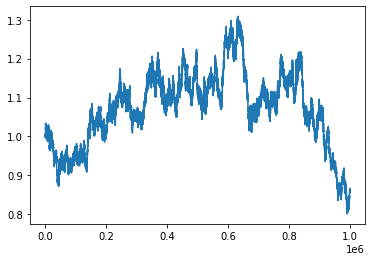

In [6]:
plt.plot(OU(T_MAX,tau,mu=1,sigma=noise_strength,dt=0.01))

In [7]:
gene.simulate(duration=T_MAX,number_trajectories=100,num_parallel=6,dt=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

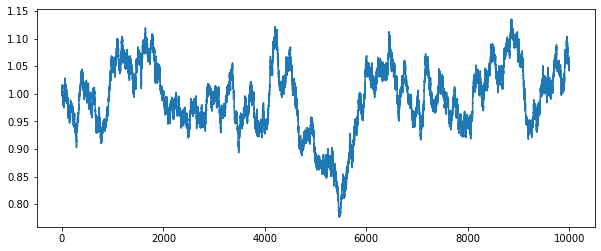

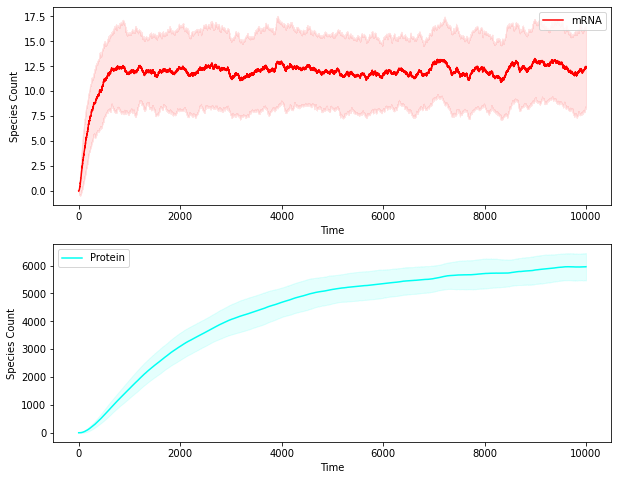

In [8]:

plt.figure(figsize=(10,4))
plt.plot(gene.times,noise)
gene.plot(['mRNA','Protein'])

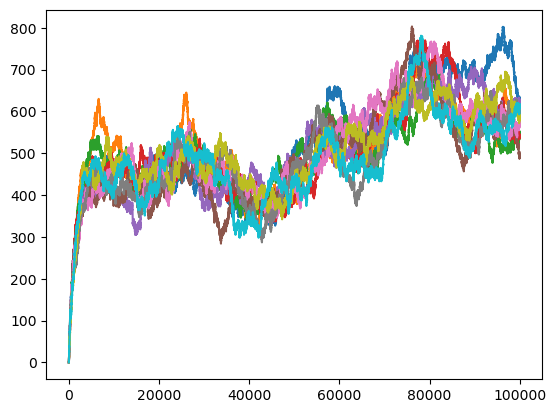

In [530]:
for protein in gene['Protein'][:10]:
    plt.plot(protein)

# mRNA

In [211]:
gene = Gillespie('mRNA')

gene.add_species({'mRNA':0})

In [212]:
# Reaction Rate
T_MAX = 10000
k_b = 10
k_d = .01
dt = 0.1

# Extrinsic Noise

tau = 100
noise_strength = .2

noise = OU(T_MAX,tau,mu=1,sigma=noise_strength,dt=dt/10)[::10]


gene.propensities = [lambda v,t: k_b*noise[t] ,
                lambda v,t: k_d * v[0]]
gene.stoichiometry = np.array(
                [[1],
                [-1]])


In [213]:
gene.simulate(duration=T_MAX,number_trajectories=100,num_parallel=6,dt=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [253]:
np.std(np.array(gene['mRNA'])[:,5000:])

99.76299010526377

In [254]:
np.corrcoef(noise[5000:],np.mean(np.array(gene['mRNA'])[:,5000:],0))

array([[1.        , 0.80944886],
       [0.80944886, 1.        ]])

In [207]:
plt.style.use('bmh')

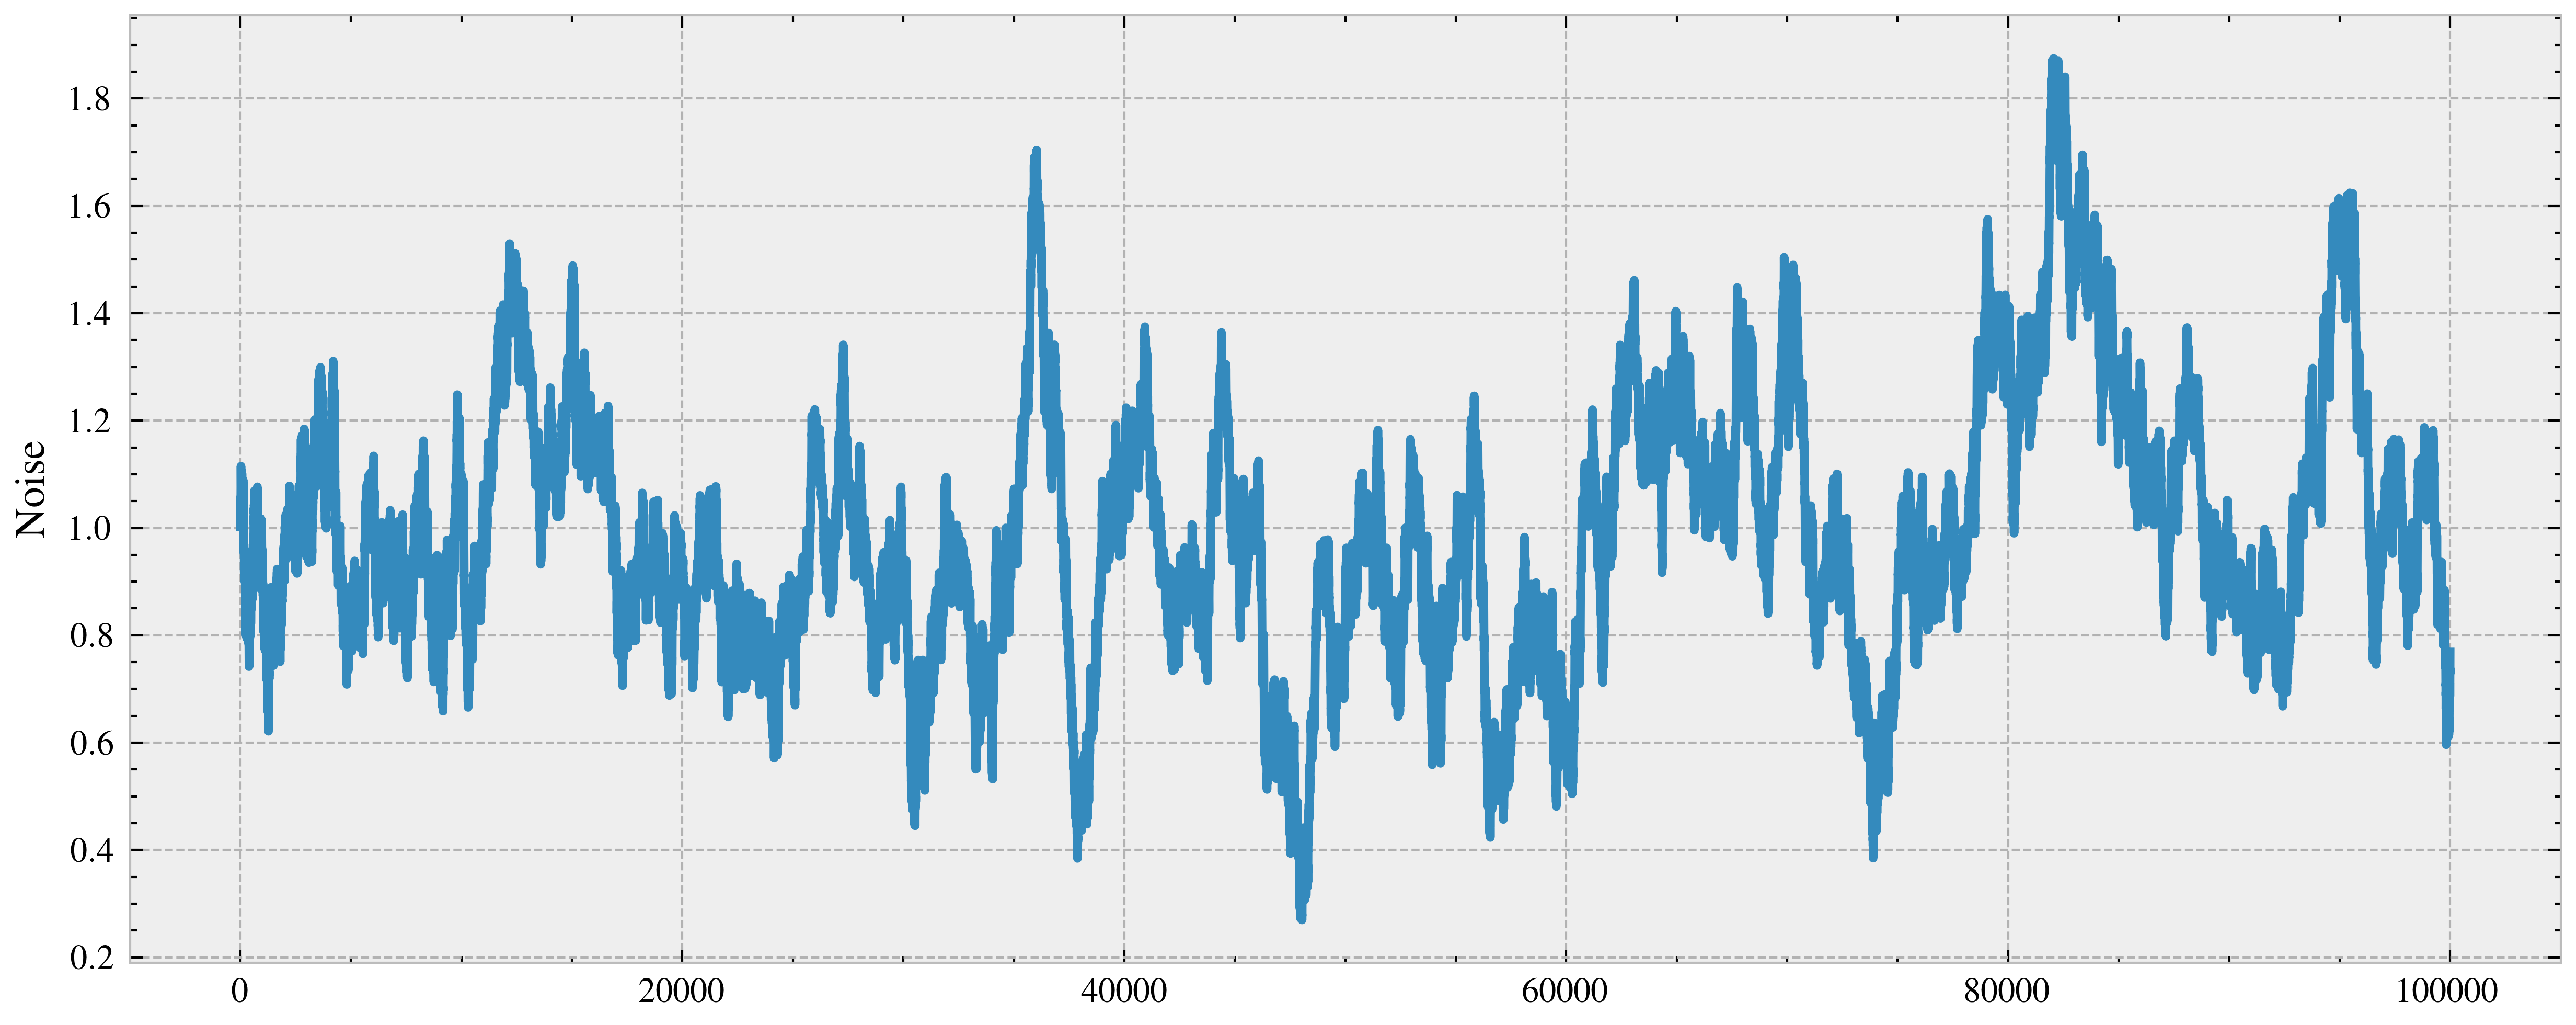

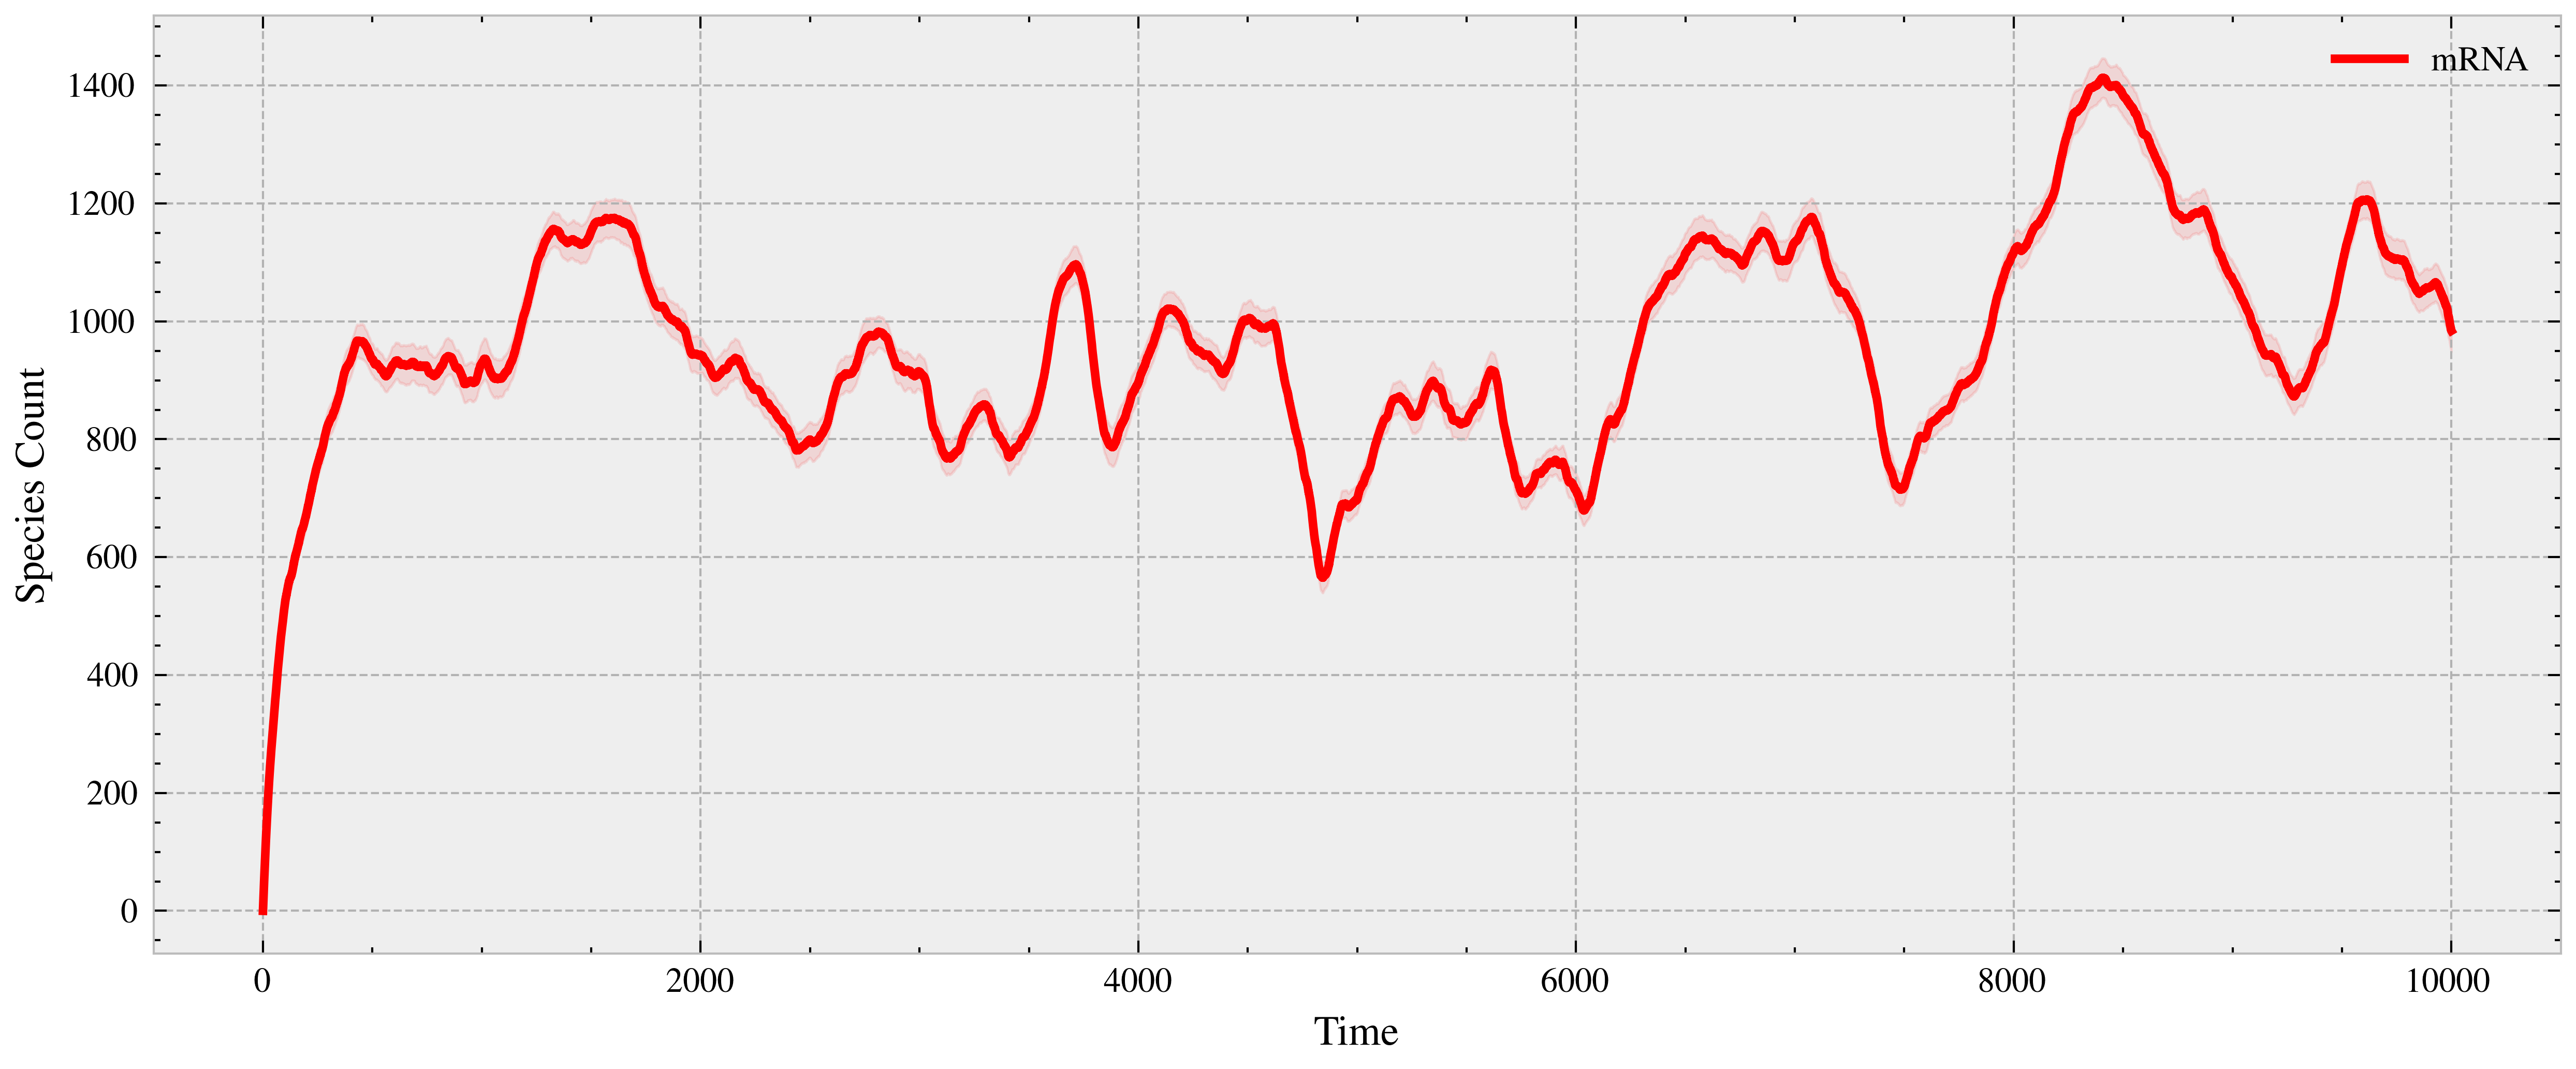

In [214]:
plt.figure(figsize=(10,4))
plt.plot(noise)
plt.ylabel('Noise')
gene.plot()

In [195]:
np.savetxt('mRNA.csv',np.array(gene['mRNA'])[:10,10000::100].T)

In [194]:
np.array(gene['mRNA'])[:10,10000::100].T

array([[1012., 1064., 1138., ..., 1082., 1072., 1118.],
       [1020., 1054., 1136., ..., 1084., 1070., 1100.],
       [1014., 1038., 1128., ..., 1086., 1072., 1124.],
       ...,
       [ 950.,  925.,  964., ...,  994.,  960.,  956.],
       [ 958.,  929.,  964., ...,  982.,  950.,  958.],
       [ 970.,  929.,  962., ...,  970.,  960.,  946.]])

In [171]:
gene['mRNA'][10000::100]

TypeError: list indices must be integers or slices, not tuple

In [218]:
np.std(np.array(gene['mRNA'])[:100,10000::100])

169.69274963387522

## Deterministic Limit

In [563]:
gene = Gillespie('Deterministic')

gene.add_species({'mRNA':0,'Protein':0})

In [564]:
# Reaction Rate
T_MAX = 10000
k_b = 10
k_d = .1
p_b = 2
p_d = 0.4
dt = 0.1

# Extrinsic Noise

tau = 1000
noise_strength = .2

noise = OU(T_MAX,tau,mu=1,sigma=noise_strength,dt=dt)


gene.propensities = [lambda v,t: k_b *noise[t],
                lambda v,t: k_d * v[0],
                lambda v,t: p_b * v[0],
                lambda v,t: p_d * v[1]]
gene.stoichiometry = np.array(
                [[1,0],
                [-1,0],
                [0,1],
                [0,-1]])


In [565]:
gene.simulate(duration=T_MAX,number_trajectories=100,num_parallel=6,dt=dt)

  0%|          | 0/100 [00:00<?, ?it/s]

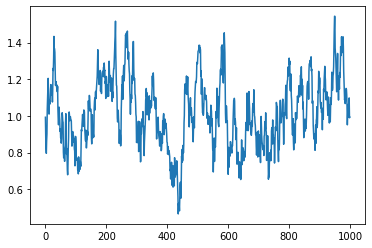

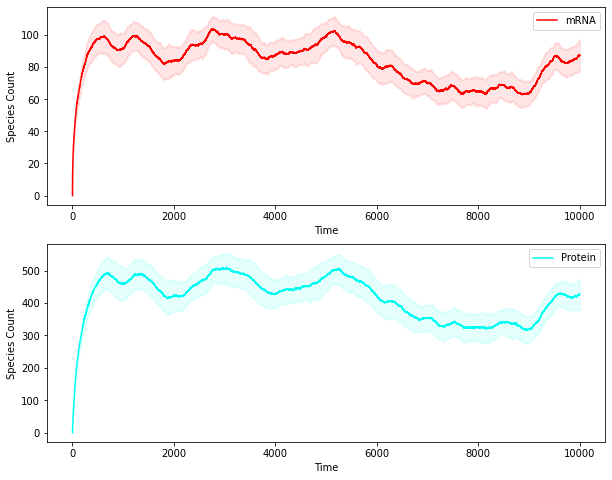

In [591]:
plt.plot(noise)
gene.plot(['mRNA','Protein'])

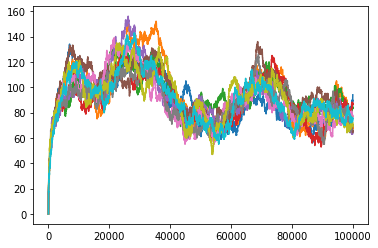

In [14]:
for protein in gene['mRNA'][:10]:
    plt.plot(protein)

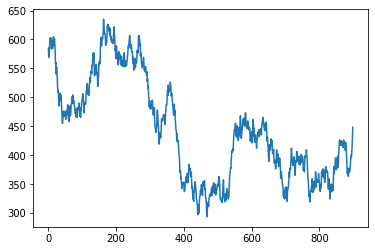

In [25]:
plt.plot(gene['Protein'][0][10000::100])

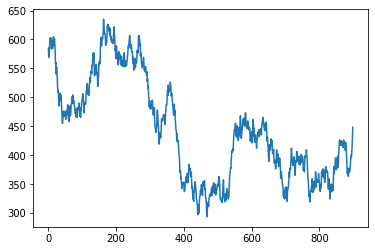

In [29]:
plt.plot(gene['Protein'][0][10000::100])

In [30]:
np.savetxt('Protein.csv',gene['Protein'][0][10000::100])

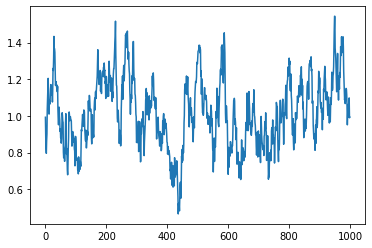

In [584]:
noise_strength = 0.2
tau = .2
dt = 0.01

noise = OU(10,tau,mu=1,sigma=noise_strength,dt=dt/10)[::10]
plt.plot(noise)
np.savetxt('noise.csv',noise)

In [585]:
len(noise)

1000

In [586]:
np.std(noise)

0.18680499721868643

# Fitting to Gaussian Process

In [61]:
protein = np.loadtxt('Protein.csv').astype(int)

In [158]:
mrna = np.loadtxt('mRNA.csv').astype(int)
len(mrna)

900

In [196]:
%%writefile gaussian.py

import stan
import numpy as np

mrna_code = """
data {
  int<lower=0> N;
  int<lower=0> k;
  int y[N,k];
}
parameters {
  real alpha;
  real beta;
  real<lower=1e-7> sigma;
  real<lower=0> lambda[N];
}
transformed parameters{
  real log_lambda[N];
  log_lambda = log(lambda);
}
model {
  alpha ~ cauchy(0.1,0.1);
  beta ~ cauchy(0.1,0.1);
  sigma ~ cauchy(0.1,0.1);
  for (n in 1:N)
    y[n] ~ poisson(lambda[n]);
  for (n in 2:N)
    log_lambda[n] ~ normal(alpha + beta * log_lambda[n-1], sigma);
}
"""

mrna = np.loadtxt('mrna.csv').astype(int)
mrna_dat = {
             'N': 900,
             'k': 10,
             'y': mrna,
            }

posterior = stan.build(mrna_code, data=mrna_dat)
fit = posterior.sample(num_chains=4, num_samples=1000)
df = fit.to_frame()
df.to_csv('mrna_trace.csv')

Overwriting gaussian.py


In [587]:
%%writefile noise.py

import stan
import numpy as np

noise_code = """
data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=1e-7> sigma;
}
model {
  alpha ~ cauchy(0.1,0.1);
  beta ~ cauchy(0.1,0.1);
  sigma ~ cauchy(0.1,0.1);
  for (n in 2:N)
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
}
"""

noise = np.loadtxt('noise.csv')
noise_dat = {
             'N': 1000,
             'y': noise,
            }

posterior = stan.build(noise_code, data=noise_dat)
fit = posterior.sample(num_chains=4, num_samples=1000)
df = fit.to_frame()
df.to_csv('noise_trace.csv')

Overwriting noise.py


In [197]:
!python gaussian.py

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/4400)
Sampling:   0% (2/4400)
Sampling:   0% (3/4400)
Sampling:   0% (4/4400)
Sampling:   2% (103/4400)
Sampling:   5% (202/4400)
Sampling:   7% (301/4400)
Sampling:   9% (400/4400)
Sampling:  11% (500/4400)
Sampling:  14% (600/4400)
Sampling:  16% (700/4400)
Sampling:  18% (800/4400)
Sampling:  20% (900/4400)
Sampling:  23% (1000/4400)
Sampling:  25% (1100/4400)
Sampling:  27% (1200/4400)
Sampling:  30% (1300/4400)
Sampling:  32% (1400/4400)
Sampling:  34% (1500/4400)
Sampling:  36% (1600/4400)
Sampling:  39% (1700/4400)
Sampling:  41% (1800/4400)
Sampling:  43% (1900/4400)
Sampling:  45% (2000/4400)
Sampling:  48% (2100/4400)
Sampling:  50% (2200/4400)
Sampling:  52% (2300/4400)
Sampling:  55% (2400/4400)
Sampling:  57% (2500/4400)
Sampling:  59% (2600/4400)
Sampling:  61% (2700/4400)
Sampling:  64% (2800/4400)
Sampling:  66% (2900/4400)
Sampling:  68% (3000/4400)
Sampling:  70% (3100/4400)
Sampling:  73% (3200/4400)
Sa

In [408]:
noise_strength,tau,dt

(0.2, 2, 0.01)

In [456]:
noise_strength*np.sqrt(2*dt/tau)

0.020000000000000004

In [198]:
df = pd.read_csv('mrna_trace.csv')
df[['alpha','beta','sigma']].describe()

,alpha,beta,sigma
count,400.000000,400.000000,400.000000
mean,0.029472,0.995724,0.011947
std,0.018750,0.002704,0.000350
min,-0.024062,0.987059,0.010985
25%,0.017235,0.993954,0.011686
50%,0.028720,0.995864,0.011940
75%,0.041904,0.997469,0.012199
max,0.089508,1.003375,0.012842


In [200]:
np.mean([np.std(df.iloc[i,11:911]) for i in range(100)])

136.04080454572176

In [199]:
tau_exp = dt/(1-df['beta'].mean())
sigma_exp = df['sigma'].mean()*np.sqrt(.5*tau_exp/dt)
sigma_exp

0.12919324730370854

In [325]:
mrna = np.loadtxt('mRNA.csv').astype(int)

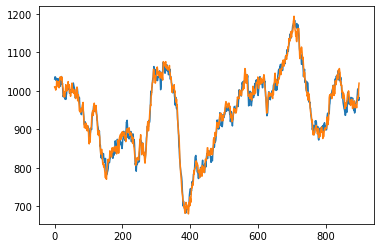

In [326]:
plt.plot(df.iloc[0,8:908].to_numpy())
plt.plot(mrna)

In [425]:
tau

2

In [431]:
tau_exp = dt/df['alpha'].mean()
tau_exp

3.130834706043409

In [432]:
df['sigma'].mean()*np.sqrt(.5*tau/dt)

0.2000384499361578

In [340]:
tau_exp,tau

(18.043194866649582, 1000)

In [312]:
noise_strength

0.2

In [386]:
percentage_error = abs(sigma_exp-noise_strength)/noise_strength
percentage_error

0.07088449656810769

In [244]:
tau_exp

18.043194866649582

In [303]:
noise_strength*np.sqrt(2*dt/tau)

0.0028284271247461905

In [222]:
dt/tau

0.005

In [80]:
!python gaussian.py

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/4400)
Sampling:   0% (2/4400)
Sampling:   0% (3/4400)
Sampling:   0% (4/4400)
Sampling:   2% (103/4400)
Sampling:   5% (202/4400)
Sampling:   7% (301/4400)
Sampling:   9% (400/4400)
Sampling:  11% (500/4400)
Sampling:  14% (600/4400)
Sampling:  16% (700/4400)
Sampling:  18% (800/4400)
Sampling:  20% (900/4400)
Sampling:  23% (1000/4400)
Sampling:  25% (1100/4400)
Sampling:  27% (1200/4400)
Sampling:  30% (1300/4400)
Sampling:  32% (1400/4400)
Sampling:  34% (1500/4400)
Sampling:  36% (1600/4400)
Sampling:  39% (1700/4400)
Sampling:  41% (1800/4400)
Sampling:  43% (1900/4400)
Sampling:  45% (2000/4400)
Sampling:  48% (2100/4400)
Sampling:  50% (2200/4400)
Sampling:  52% (2300/4400)
Sampling:  55% (2400/4400)
Sampling:  57% (2500/4400)
Sampling:  59% (2600/4400)
Sampling:  61% (2700/4400)
Sampling:  64% (2800/4400)
Sampling:  66% (2900/4400)
Sampling:  68% (3000/4400)
Sampling:  70% (3100/4400)
Sampling

In [89]:
df = pd.read_csv('new.csv')
df['sigma']

0      0.014879
1      0.013683
2      0.015139
3      0.015737
4      0.015464
         ...   
395    0.016871
396    0.015103
397    0.016029
398    0.013929
399    0.016298
Name: sigma, Length: 400, dtype: float64

<AxesSubplot:ylabel='Density'>

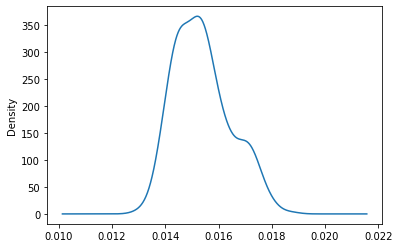

In [103]:
df['sigma'].plot.kde()

<AxesSubplot:ylabel='Density'>

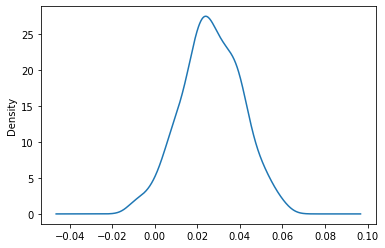

In [114]:
df['alpha'].plot.kde()

<AxesSubplot:ylabel='Density'>

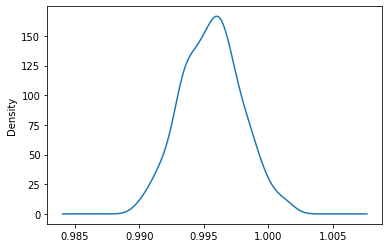

In [115]:
df['beta'].plot.kde()

<AxesSubplot:>

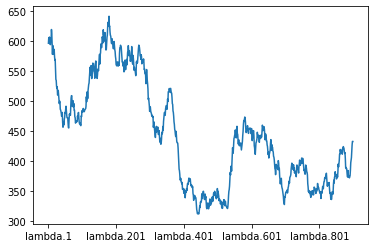

In [116]:
df.iloc[0,8:908].plot()

# Previous Work

In [3]:
def gillespie_step(T_MAX,BURN_IN,TAU,Q_TRAJ,Reactant,Propensity):
    # Reaction Rates

    k_d = 1
    X = []
    Y = []
    c_b=.2
    c_f=.5
    dt = 0.01
    T_BURN_IN = int(BURN_IN/dt)
    T_TAU = int(TAU/dt)
    t = 0
    x = 0
    q = 20
    y = 0
    q0 = 1
    q1 = 0
    indx = 0

    while t<T_MAX:
        [r1,r2]=np.random.rand(2)
        q = Q_TRAJ[indx]
        indx += 1

        
        p1 = c_f*q0
        p2 = c_b*q1
        p3 = k_b*q1
        p4 = k_d*x


        if r2<p1*dt:
            q1=1
            q0=0
        
        elif r2<(p1+p2)*dt:
            q1=0
            q0=1
    
        elif r2<(p1+p2+p3)*dt:
            x=x+1
        
        elif r2<(p1+p2+p3+p4)*dt:
            if x>0:
                x=x-1
            
        X.append(x)

        p1 = q
        p2 = k_d*y
        p_net = p1+p2
    
        if r2<p1*dt:
            y = y+1

        elif r2<p_net*dt:
            if y>0:
                y = y-1
        
        Y.append(y)

        t=t+dt

        X.append(np.mean(X_inst[-1000:]))
        Y.append(np.mean(Y_inst[-1000:]))
    return(np.array([X[T_BURN_IN::T_TAU],Y[T_BURN_IN::T_TAU]]))


In [11]:
def gillespie_step(T_MAX,BURN_IN,TAU,Q_TRAJ):
    # Reaction Rates

    k_d = 1
    X_inst = []
    Y_inst = []
    X = []
    Y = []
    
    dt = 0.01
    T_BURN_IN = int(BURN_IN/dt)
    T_TAU = int(TAU/dt)
    t = 0
    x = 0
    q = 20
    y = 0
    indx = 0

    while t<T_MAX:
        [r1,r2]=np.random.rand(2)
        q = Q_TRAJ[indx]
        indx += 1
            
        p1 = q
        p2 = k_d*x
        p_net = p1+p2
        
        if r1<p1*dt:
            x = x+1

        elif r1<p_net*dt:
            if x>0:
                x = x-1
        
        X_inst.append(x)

        p1 = q
        p2 = k_d*y
        p_net = p1+p2
    
        if r2<p1*dt:
            y = y+1

        elif r2<p_net*dt:
            if y>0:
                y = y-1
        
        Y_inst.append(y)

        t=t+dt

        X.append(np.mean(X_inst[-1000:]))
        Y.append(np.mean(Y_inst[-1000:]))
    return(np.array([X[T_BURN_IN::T_TAU],Y[T_BURN_IN::T_TAU]]))


In [14]:
nreps = 100
T_MAX = 200
TAU = 10
BURN_IN = 20
Q_TRAJ = OU(T_MAX,TAU,mu=20,sigma=2.5)
result = np.array(Parallel(n_jobs=6)(delayed(gillespie_step)(T_MAX,BURN_IN,TAU,Q_TRAJ) for i in tqdm(range(nreps))))

  0%|          | 0/100 [00:00<?, ?it/s]

IndexError: index 20000 is out of bounds for axis 0 with size 20000

In [13]:
X = result[:,0,:].flatten()
Y = result[:,1,:].flatten()

NameError: name 'result' is not defined

In [7]:
#Reaction Rates
k_b = 1
k_d = 1

X = []
Y = []
nreps = 1000
T_max = 20


for n in tqdm(range(nreps)):
    X_inst = []
    Y_inst = []
    dt = 0.01
    t = 0
    x = 0
    q = 20
    y = 0
    indx = 0
    #q = np.random.normal(20,scale=2)

    while t<T_max:
        [r1,r2]=np.random.rand(2)
        q = Q[indx]
        indx += 1
        
        p1 = k_b*q
        p2 = k_d*x
        p_net = p1+p2
        
        if r1<p1*dt:
            x = x+1

        elif r1<p_net*dt:
            if x>0:
                x = x-1
        
        X_inst.append(x)

        p1 = k_b*q
        p2 = k_d*y
        p_net = p1+p2
        
        if r2<p1*dt:
            y = y+1

        elif r2<p_net*dt:
            if y>0:
                y = y-1
        
        Y_inst.append(y)

        t=t+dt

    # X.append(np.mean(X_inst[-1000:]))
    # Y.append(np.mean(Y_inst[-1000:]))
    X = X+X_inst[-1000:]
    Y = Y+Y_inst[-1000:]

X = np.array(X)
Y = np.array(Y)

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: list index out of range

# Intrinsic Extrinsic Noise

In [34]:
np.var(gene["mRNA"])

6.506040615955553

In [21]:
X = X/np.mean(X)
Y = Y/np.mean(Y)

In [86]:
data = np.loadtxt("simulated_ext_int.csv",delimiter=",")

In [99]:
X = data[:,0]
Y = data[:,1]


In [100]:
X = X[:500]
Y = Y[:500]

In [26]:
plt.style.use(['ieee','science'])

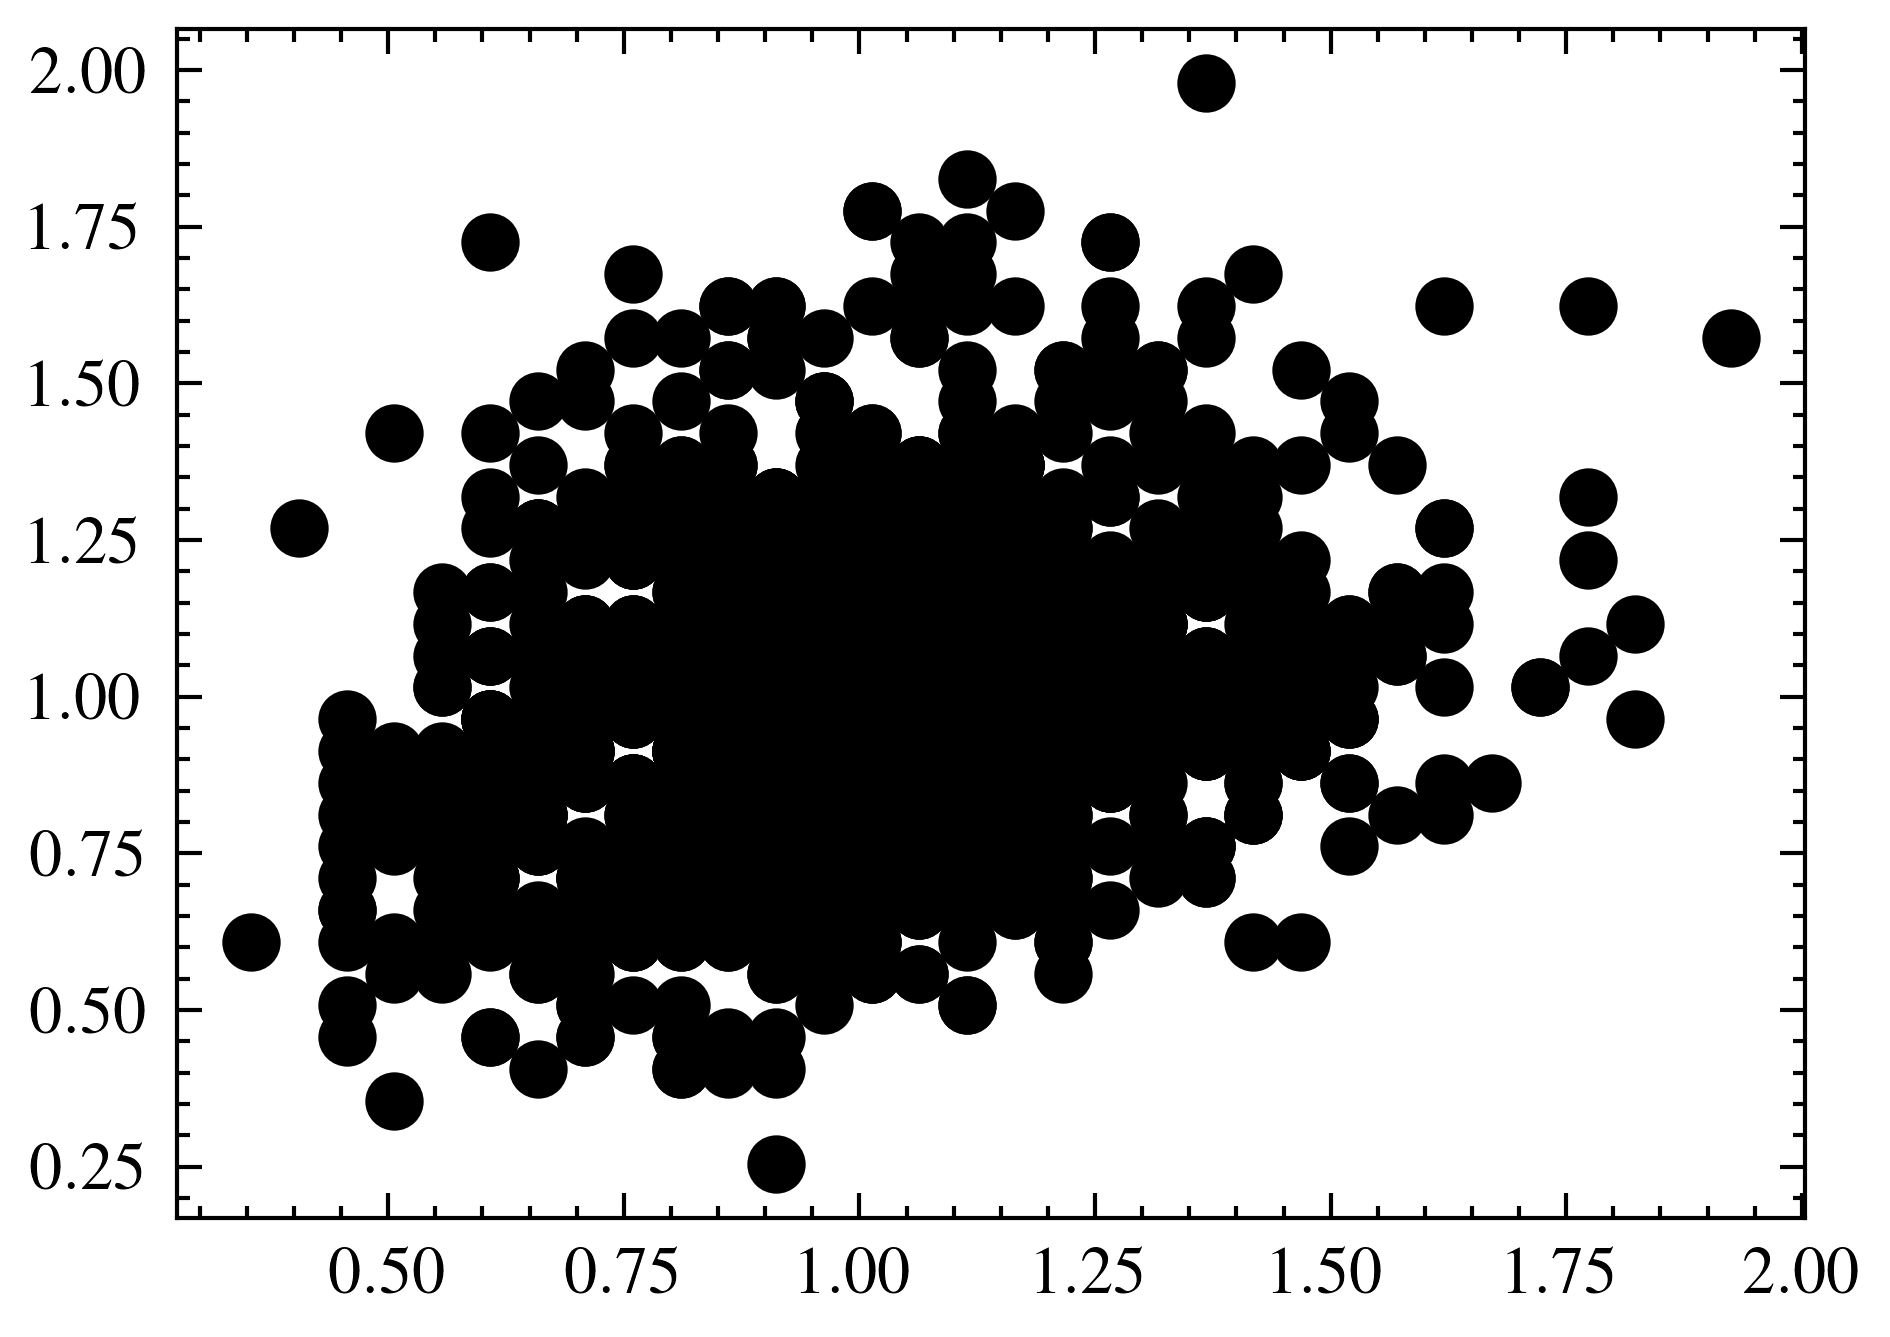

In [29]:
plt.plot(X,Y,'ko')

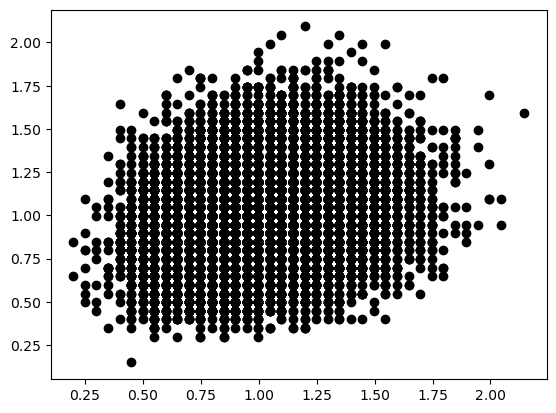

In [19]:
plt.plot(X,Y,'ko')

In [122]:
%%writefile elowitz.py

import stan
import numpy as np

mrna_code = """
data {
  int<lower=0> N;         // number of data points
  int c[N];              // cfp
  int y[N];              // cfp
}
parameters {
  real mu;                // population treatment effect
  real sigma;
  real<lower=0> lambda[N];         // unscaled deviation from mu by school
}

model {
  for (i in 1:N){
    c[i] ~ poisson(lambda[i]);
    y[i] ~ poisson(lambda[i]);
    lambda[i] ~ normal(mu,sigma);
  }

}
"""

data = np.loadtxt("simulated_ext_int.csv",delimiter=",")
X = data[:1000,0].astype(int)
Y = data[:1000,1].astype(int)
mrna_dat = {
             'N': 1000,
             'c': X,
             'y': Y
            }

posterior = stan.build(mrna_code, data=mrna_dat)
fit = posterior.sample(num_chains=4, num_samples=1000)
df = fit.to_frame()
df.to_csv('elowitz_trace.csv')

Overwriting elowitz.py


In [123]:
!python elowitz.py

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/8w/hx19xvh91tz1slr75dswkr100000gs/T/httpstan_lmvz_7qh/model_akyjfoox.stan', line 17, column 26: A normal distribution is given parameter sigma as a scale parameter (argument 2), but sigma was not constrained to be strictly positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200

In [124]:
df = pd.read_csv('elowitz_trace.csv')

In [125]:
vi_1000 = df['mu']
ve_1000 = df['sigma'].to_numpy()**2

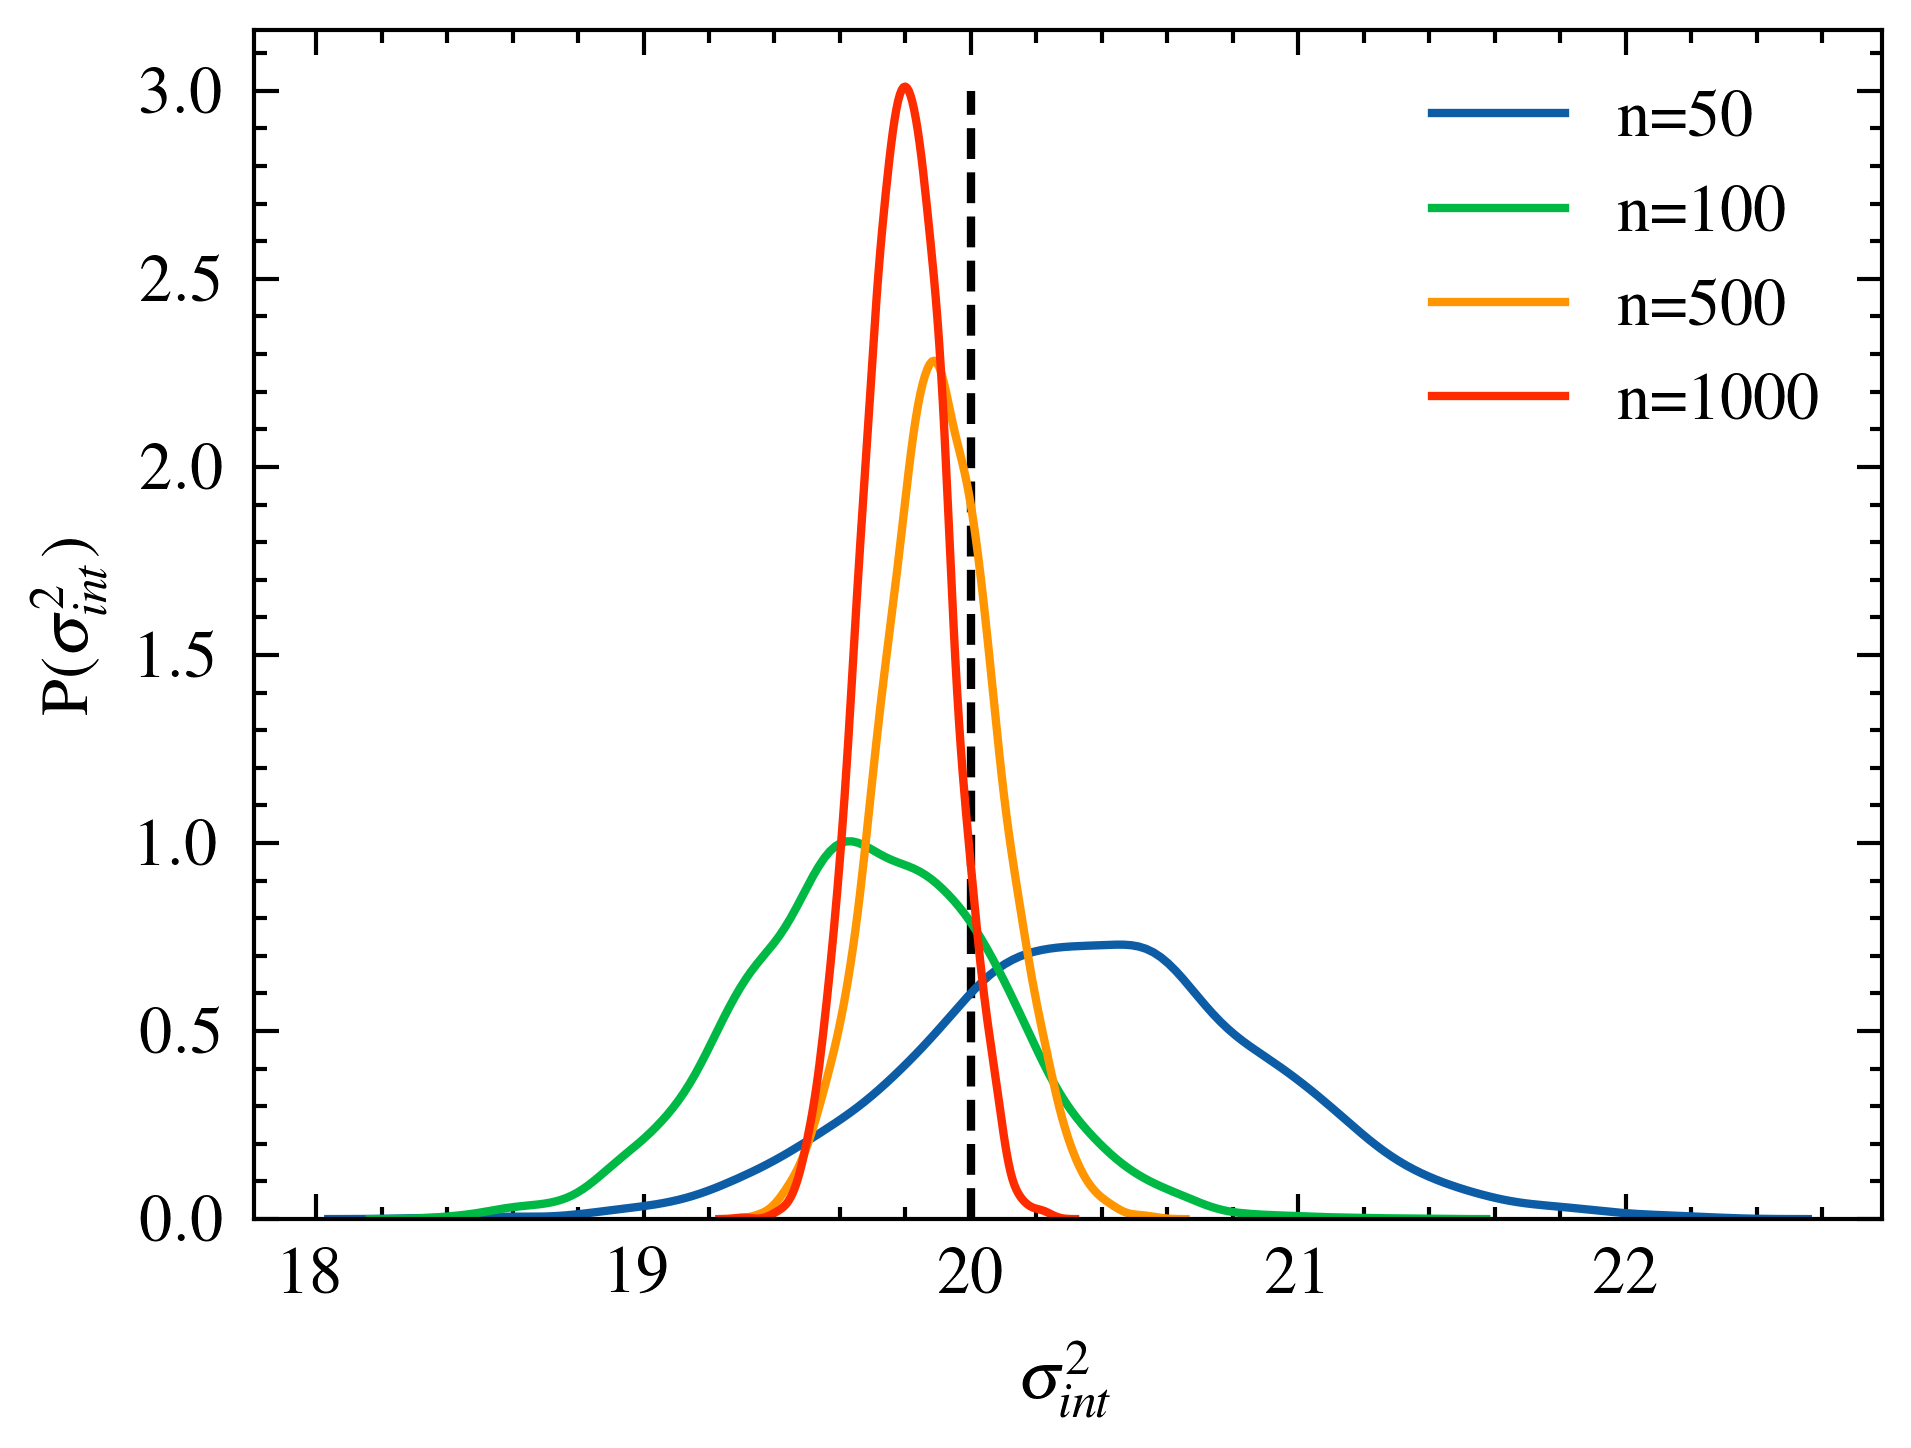

In [130]:
import seaborn as sns

sns.kdeplot(vi_50,label='n=50')
sns.kdeplot(vi_100,label='n=100')
sns.kdeplot(vi_500,label='n=500')
sns.kdeplot(vi_1000,label='n=1000')
plt.xlabel(r'$\sigma_{int}^2$')
plt.ylabel(r'P($\sigma_{int}^2$)')
plt.vlines(20,0,3,linestyle='--',color='k')
plt.legend()

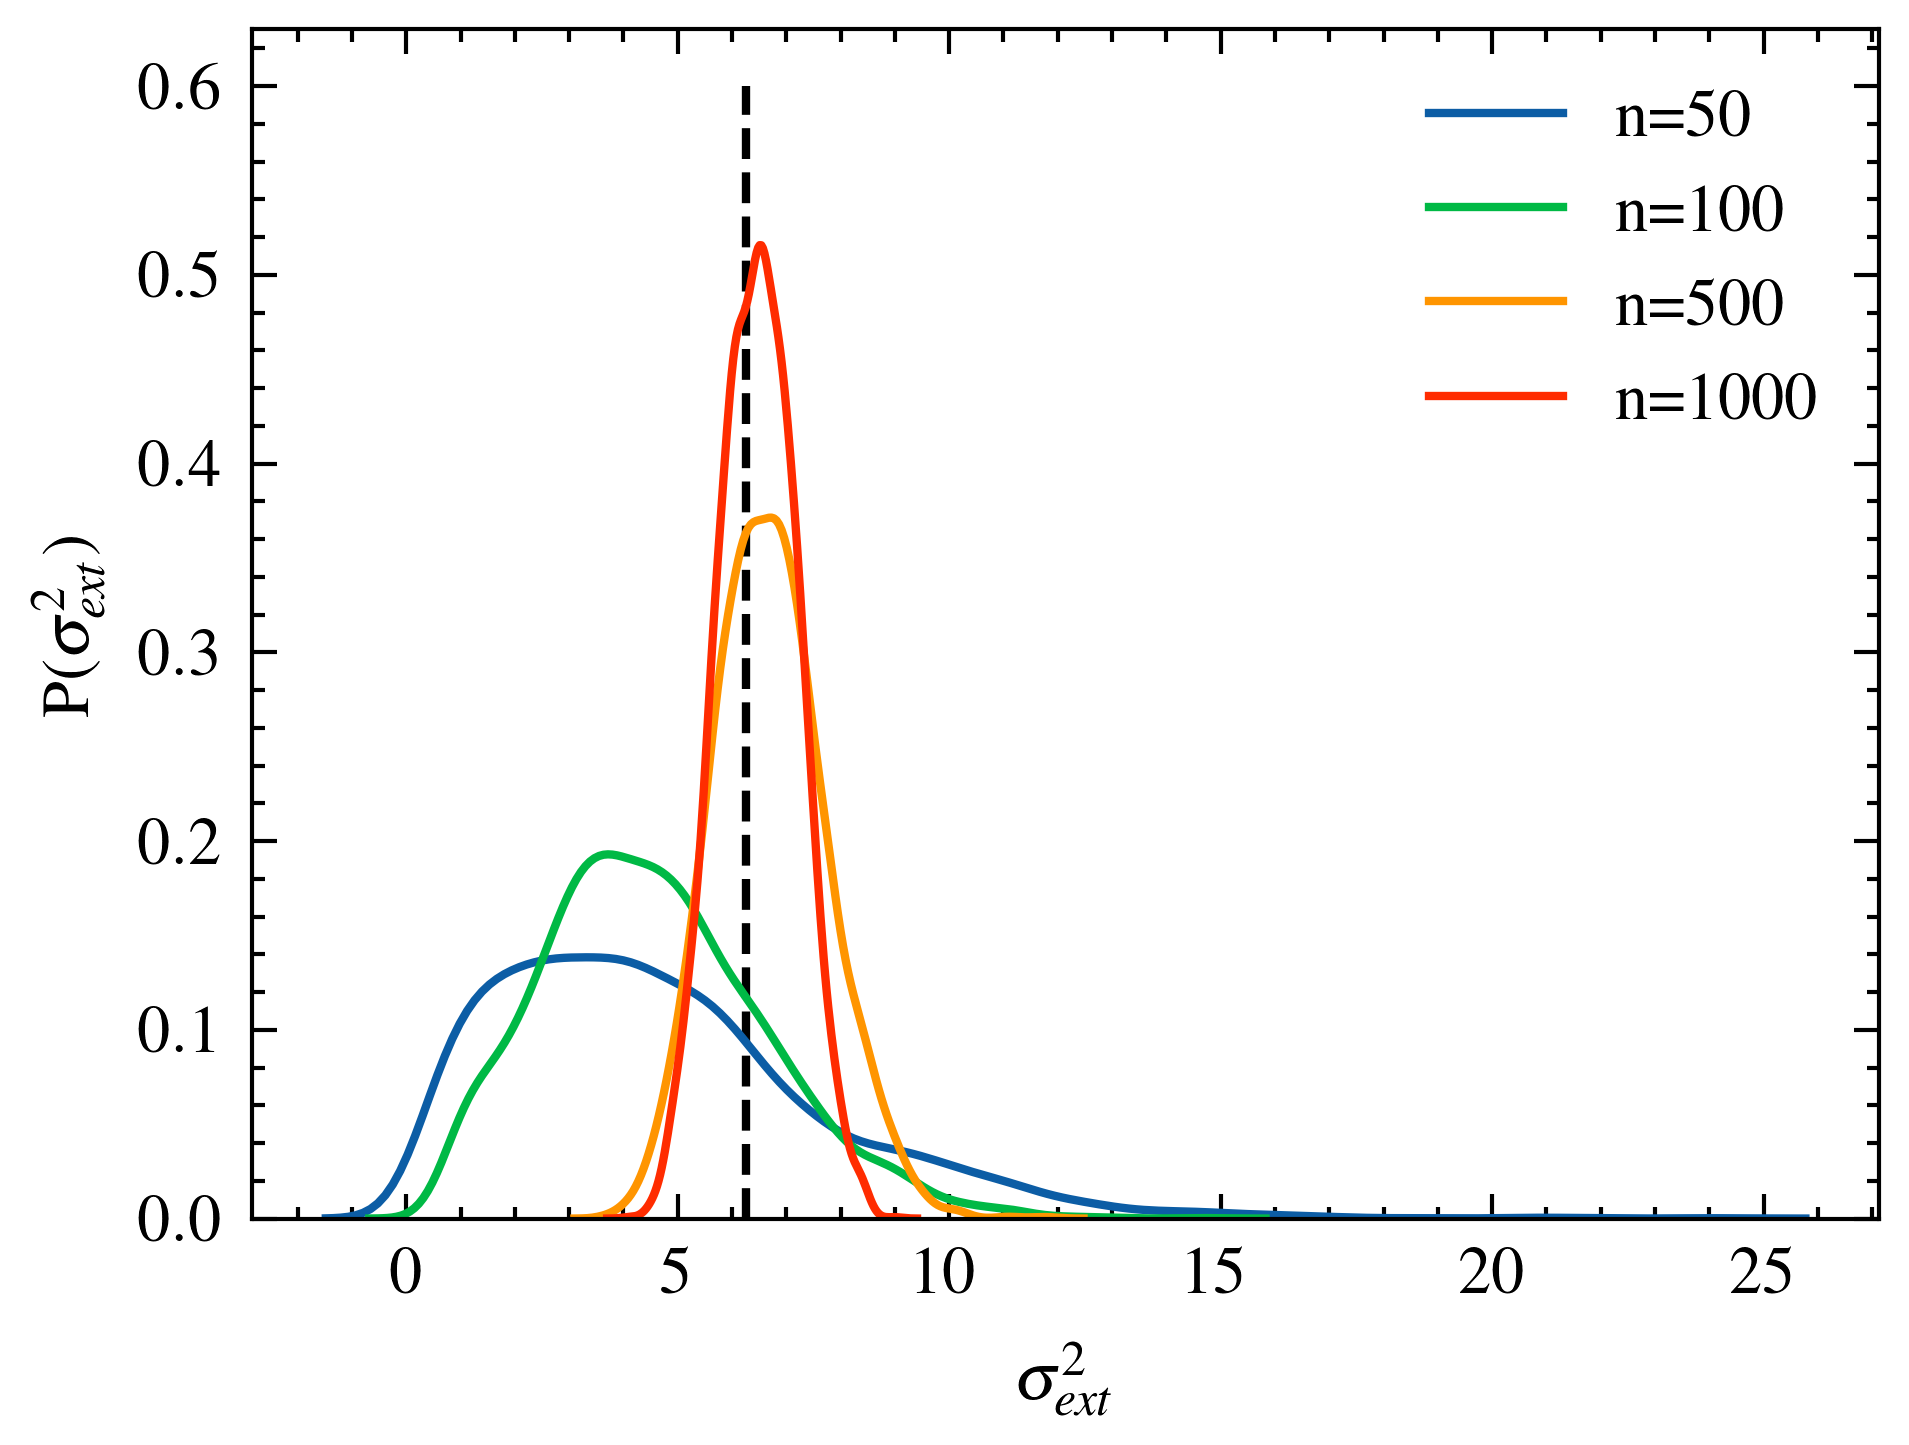

In [129]:
sns.kdeplot(ve_50,label='n=50')
sns.kdeplot(ve_100,label='n=100')
sns.kdeplot(ve_500,label='n=500')
sns.kdeplot(ve_1000,label='n=1000')

plt.xlabel(r'$\sigma_{ext}^2$')
plt.ylabel(r'P($\sigma_{ext}^2$)')
plt.vlines(6.25,0,0.6,linestyle='--',color='k')
plt.legend()

In [95]:
(df['sigma'].mean())**2

4.1533667924064686

In [55]:
(df['sigma_e'].mean())**2

16.30489114921232

In [20]:
#Q_TRAJ = OU(2000,10,mu=20,sigma=2)
np.var(Q_TRAJ)

6.55737274884402

In [101]:
i = (X-Y)/np.sqrt(2)
z = (X+Y-np.mean(X)-np.mean(Y))/2

In [129]:
np.savetxt("simulated_ext_int.csv",np.array([X,Y]).T, delimiter=",")

In [128]:
np.array([X,Y]).T.shape

(19900, 2)

In [102]:
np.var(i),np.var(z)-.5*np.var(i)

(19.062199999999997, 6.966084000000002)

# Rough

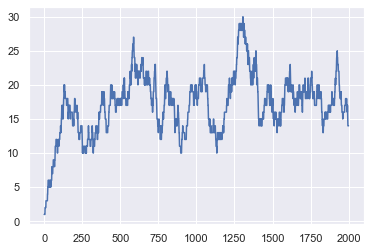

In [493]:
plt.plot(X_inst)

In [77]:
dt = .1
nreps = 100
tau = 1/k_d
X = []
Y = []
    
for rep in tqdm(range(nreps)):
    x=0
    t=0
    i=0
    X_inst = []
            
    while t<T_max:
        [r1,r2]=np.random.rand(2)
        q = np.random.normal(5,scale=1)
        p1 = k_b*q
        p2 = k_d*x
        p_net = p1+p2

        t_react = -np.log(r1)/p_net
        t=t+t_react
            
        if r2<p1/p_net:
            x=x+1
        
        else:
            x=x-1

        
        while i<np.min([int(t/dt),int(T_max/dt)]):
            if t>T_max/2:
                if rep<nreps/2:
                    X.append(x)
                
                else:
                    Y.append(x)
            i = i+1
                
        
        # if t>T_max/2:
        #     X_inst.append(x)
        

    # if rep<nreps/2:
    #     X.append(np.mean(X_inst))
        
    # else:
    #     Y.append(np.mean(X_inst))
        

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extrinsic vs Intrinsic Noise')

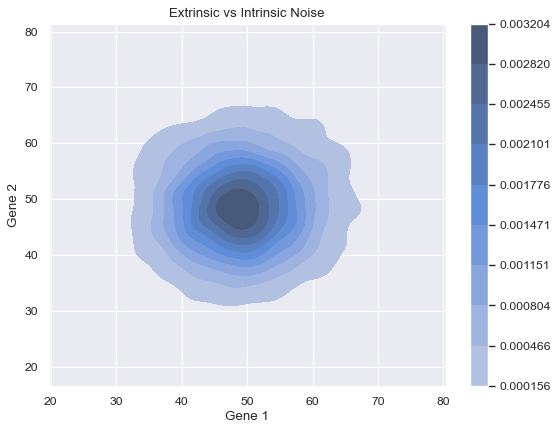

In [79]:
import seaborn as sns
sns.set(color_codes=True)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# Basic 2D density plot
sns.set_style("darkgrid")
sns.kdeplot(X,Y, shade=True,cbar=True)
plt.xlabel("Gene 1")
plt.ylabel("Gene 2")
plt.title("Extrinsic vs Intrinsic Noise")

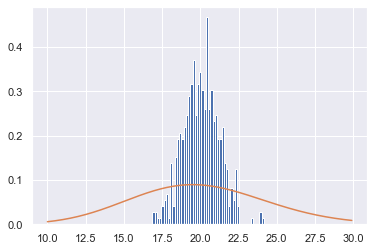

In [160]:
from scipy.special import factorial

plt.hist(X,density=True,bins=50)
t = np.arange(10, 30, 0.1)
d = np.exp(-20)*np.power(20, t)/factorial(t)
plt.plot(t,d)
